# Comparison of drift-diffusion simulation with Gouy-Chapmann theory

In this notebook, diluted electrolyte between metallic electrodes is simulated. 

The electrostatic potential in electrical double layer is plotted, and compared with analytical Gouy-Chapmann (GC) solution given by equations:

$\kappa=\sqrt{\frac{2c_0e^2}{\epsilon\epsilon_0k_BT}}$

$\psi=\frac{2k_BT}{e}*\ln \frac{e^{y_0/2}+1+(e^{y_0/2}-1)*e^{-\kappa x}}{e^{y_0/2}+1-(e^{y_0/2}-1)*e^{-\kappa x}}$

$y_0=\frac{e\psi_0}{k_BT}$

with $c_0$ being ion concentration, $\psi$ is the electrostatic potential and other symbols have usual meaning.

To ensure applicability of GC theory, low concentration of ions is assumed. Differences between the simulation and analytical results are caused by depleting electrolyte of ions.

In [1]:
%matplotlib inline
import matplotlib.pylab as plt
from oedes import bdf1adapt, models, testing, progressbar, init_notebook
init_notebook()
from oedes.fvm import mesh1d
import numpy as np
import scipy.constants

In [2]:
def run(mesh, c, appl_v):
    model = models.BaseModel()
    models.add_ions(model, mesh, zc=1,za=-1)
    model.setUp()
    params = {'T': 300.,
              'electrode0.voltage': 0,
              'electrode1.voltage': 0,
              'electrode0.workfunction': 0,
              'electrode1.workfunction': 0,
              'cation.mu': 1e-11,
              'anion.mu': 1e-11,
              'epsilon_r': 3.}
    xinit = model.X.copy()
    for eq in model.species:
        xinit[eq.idx] = c
    params['electrode0.voltage'] = appl_v
    for t, x, xt, out in bdf1adapt(model, xinit, params, 0., t1=1e10, dt=1e-9):
        o = out()
    return mesh, o

In [3]:
def edl_solution(appl_v, x, c, T=300., epsi_r=3.):
    kT_q = scipy.constants.Boltzmann * T / scipy.constants.elementary_charge
    K = np.sqrt(2 * c * scipy.constants.elementary_charge /
                (kT_q * scipy.constants.epsilon_0 * epsi_r))
    y0 = appl_v * 0.5 / kT_q
    t = np.exp(y0 / 2.)
    u = (t - 1.) * np.exp(-K * x)
    v = t + 1
    psi = 2 * kT_q * np.log((v + u) / (v - u))
    return psi

In [4]:
def test(appl_v):
    c = 1e24
    mesh, o = run(mesh1d(1e-6, dx_boundary=1e-14), c, appl_v)
    x = mesh.cells['center']
    psi = edl_solution(appl_v, x, c)
    testing.store(o['potential'] - appl_v / 2., rtol=1e-7, atol=1e-7)
    plt.plot(mesh.cells['center'], o['potential'] - appl_v / 2., '-')
    plt.plot(x, psi, '--')
    plt.xscale('log')

Text(0,0.5,'potential')

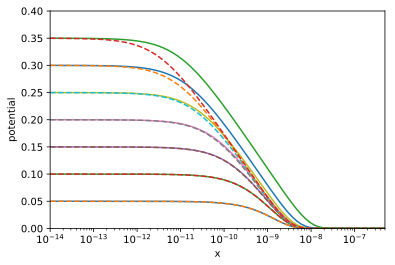

In [5]:
for v in progressbar([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7],'V'):
    test(v)
plt.ylim([0, 0.4])
plt.xlim([1e-14, 0.5e-6])
plt.xlabel('x')
plt.ylabel('potential')


---
This file is a part of __oedes__, an open source organic electronic device 
simulator. For more information, see <https://www.github.com/mzszym/oedes>.
